<a href="https://colab.research.google.com/github/rawat999/Car_Segmentation/blob/master/car_studio_background_remove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predictions

#### Setup Drive path and extract test images

In [1]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Car_Segmentation/carvana_dataset.zip'
zip_file = zipfile.ZipFile(path)
zip_file.extractall('/content/')
zip_file.close()

Mounted at /content/gdrive


### Import necessary libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

#### setup path for images and models

In [3]:
root = '/content/'
dataset_path = root + 'Car/'
images_path = os.path.join(dataset_path, 'val', 'images')

drive_path = os.path.join(root, 'gdrive/MyDrive/Car_Segmentation/')
model_path = os.path.join(drive_path, 'trained_model')
bg_path = os.path.join(drive_path, 'background_images')

IMG_SIZE = 224

##### Load trained model

In [4]:
# Load trained model
model = tf.keras.models.load_model(os.path.join(model_path, 'car_segment_augment.h5'), 
                                   compile=False)

model.summary()

Model: "Car_Segmentation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
MobileNetV2 (Functional)        [(None, 112, 112, 96 2257984     image[0][0]                      
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 14, 14, 576)  6637824     MobileNetV2[0][4]                
__________________________________________________________________________________________________
add_8 (Add)                     (None, 14, 14, 576)  0           sequential_8[0][0]               
                                                                 MobileNetV2[0][3] 

### Function for image display

In [5]:
def display_sample(display_list,label_list):
    plt.figure(figsize=(15, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title('{}'.format(label_list[i%len(label_list)]))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        print()
        plt.axis('off')
    plt.show()

### Function for reading images and predictions with new background

In [6]:
def parse_image(img_path: str, prediction=True, background=False, image_size=(224, 224)):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if (prediction == True) & (background == False):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.expand_dims(image, axis=0)
  if background:
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, image_size)
  return image

def get_image_with_new_bg(original_image, original_bg, predicted_mask):
  predicted_mask = tf.where(predicted_mask <= 0.5, 0.0, predicted_mask)
  predicted_mask = tf.where(predicted_mask > 0.5, 1.0, predicted_mask)
  predicted_mask = tf.image.resize(predicted_mask[0], size=original_image.shape[:-1])
  image_with_new_bg = (original_image * predicted_mask) + (original_bg*(1-predicted_mask))
  return image_with_new_bg, predicted_mask

def remove_background(image_path, background_image_path):
  input_image = parse_image(image_path)
  image = parse_image(image_path, prediction=False)
  bg_image = parse_image(background_image_path, background=True, image_size=image.shape[:-1])
  mask = model.predict(input_image)
  new_image, mask = get_image_with_new_bg(image, bg_image, mask)
  display_sample([image, new_image], 
                ['Original Image', 'Image with New Background'])

### Final Prediction and images with new background

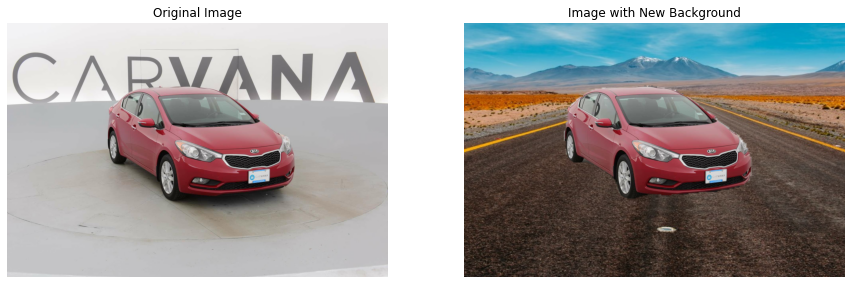

In [52]:
input_files = os.listdir(images_path)
bg_files = os.listdir(bg_path)
i = 250 #int(input("Enter image number (between 0 to {}): ".format(len(input_files)-1)))# 233, 249
j = 2 #int(input("Enter background image number (between 0 to {}): ".format(len(bg_files)-1)))
remove_background(image_path = os.path.join(images_path, input_files[i]),
                  background_image_path=os.path.join(bg_path, bg_files[j]))